# Compare Twitter and Reddit Populations

## Restricted to YouTube

This script evaluates how similar subsets of Twitter and Reddit populations are within platform and across platform.
The populations we test are:
- Random US Twitter users active in 2015-2018
    - Must have tweeted >= 100 times in this time frame
- Politically engaged US Twitter users active in 2015-2018
    - Must have tweeted >= 100 times in this time frame
    - Must follow at least 5 politicians
- IRA Twitter accounts identified by Twitter
- Random Reddit accounts  active in 2015-2018
    - Must have posted/commented >= 100 times in this time frame
- Politically engaged Redditors  active in 2015-2018
    - Must have posted/commented >= 100 times in subreddits /r/politics identifies as US-political in this time frame
- IRA Reddit accounts identified by Reddit

In [1]:
%matplotlib inline

In [2]:
import json
import time
import string
import datetime
import matplotlib

import scipy.stats

import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt

In [3]:
import sklearn.preprocessing
import sklearn.metrics

In [4]:
from utils.youtube import strip_video_id_from_url

In [5]:
def convert_date(date):
    return datetime.datetime.strptime(date, "%a %b %d %H:%M:%S +0000 %Y")

def convert_time(timestamp):
    created_time = timestamp
    if ( isinstance(created_time, str) ):
        created_time = int(created_time)
        
    d = datetime.datetime.utcfromtimestamp(created_time)
    return d

def get_top_tlds(links_df, user_id_field, top_n=100):
    tld_user_counts = {}
    for tld, group in links_df.groupby("tld"):
        local_users = set(group[user_id_field])
        tld_user_counts[tld] = len(local_users)

    return sorted(tld_user_counts, key=tld_user_counts.get, reverse=True)[:top_n]

def links_df_to_shares(links_df, domains, user_id_field):
    user_shares = []

    for user,user_posts in links_df.groupby(user_id_field):
        local_tld_counts = dict(user_posts["tld"].value_counts().items())
        local_vector = [local_tld_counts.get(x, 0) for x in domains]
        user_shares.append([user] + local_vector)

    return pd.DataFrame(user_shares, columns=[user_id_field] + domains)

def links_to_norm_matrix(links_df, domains, user_id_field):
    if ( type(domains) == set ):
        domains = list(domains)
        
    shares_df = links_df_to_shares(links_df, domains, user_id_field)
    return sklearn.preprocessing.normalize(shares_df[domains], norm="l2", axis=1)

def get_top_channels(yt_df, user_id_field, top_n=100):
    channel_user_counts = {}
    for channel, group in yt_df.groupby("channel_id"):
        local_users = set(group[user_id_field])
        channel_user_counts[channel] = len(local_users)

    return sorted(channel_user_counts, key=channel_user_counts.get, reverse=True)[:top_n]

def channels_df_to_shares(links_df, channels, user_id_field):
    user_shares = []

    for user,user_posts in links_df.groupby(user_id_field):
        local_chan_counts = dict(user_posts["channel_id"].value_counts().items())
        local_vector = [local_chan_counts.get(x, 0) for x in channels]
        user_shares.append([user] + local_vector)

    return pd.DataFrame(user_shares, columns=[user_id_field] + channels)

def channels_to_norm_matrix(links_df, channels, user_id_field):
    if ( type(channels) == set ):
        channels = list(channels)
        
    shares_df = channels_df_to_shares(links_df, channels, user_id_field)
    return sklearn.preprocessing.normalize(shares_df[channels], norm="l2", axis=1)


In [6]:
top_n_channels = 250
bootstrap_count = 5000

In [7]:
short_domain_map = {
    "abcn.ws": "abcnews.go.com",
    "amzn.to": "amazon.com",
    "apne.ws": "apnews.com",
    "apple.co": "apple.com",
    "bbc.in": "bbc.com",
    "ble.ac": "bleacherreport.com",
    "bloom.bg": "bloomberg.com",
    "bzfd.it": "buzzfeed.com",
    "cbsloc.al": "cbslocal.com",
    "cnb.cx": "cnbc.com",
    "cnn.it": "cnn.com",
    "cnn.it": "cnn.com",
    "dailym.ai" : "dailymail.co.uk",
    "econ.st": "economist.com",
    "es.pn": "espn.com",
    "fxn.ws": "foxnews.com",
    "hill.cm": "thehill.com",
    "huff.to" : "huffingtonpost.com",
    "lat.ms": "latimes.com",
    "lnkd.in": "linkedin.com",
    "n.pr": "npr.org",
    "nbcnews.to": "nbcnews.com",
    "nydn.us": "nydailynews.com",
    "nyp.st": "nypost.com",
    "nyti.ms": "nytimes.com",
    "on.rt.com": "rt.com",
    "on.wsj.com": "wsj.com",
    "politi.co": "politico.com",
    "redd.it": "reddit.com",
    "reut.rs": "reuters.com",
    "thebea.st": "thedailybeast.com",
    "ti.me": "time.com",
    "tmblr.co": "tumblr.com",
    "usat.ly": "usatoday.com",
    "wapo.st": "washingtonpost.com",
    "wp.me": "wordpress.com",
    "wpo.st": "washingtonpost.com",
    "yhoo.it": "yahoo.com",
    "youtu.be": "youtube.com",
}

In [8]:
twitter_links_df_rand = pd.read_csv("twitter_random_us_sample_links.csv",
    converters={"created_at": convert_date})
twitter_links_df_poli = pd.read_csv("twitter_political_us_sample_links.csv",
    converters={"created_at": convert_date})
twitter_links_df_ira = pd.read_csv(
    "twitter_ira_links.csv",
    converters={"created_at": lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")}
)

In [9]:
twitter_links_df_rand["tld"] = twitter_links_df_rand["tld"].apply(lambda x: short_domain_map.get(x, x))
twitter_links_df_poli["tld"] = twitter_links_df_poli["tld"].apply(lambda x: short_domain_map.get(x, x))
twitter_links_df_ira["tld"] = twitter_links_df_ira["tld"].apply(lambda x: short_domain_map.get(x, x))

In [10]:
reddit_links_df_rand = pd.read_csv("reddit_random_links.csv",
    converters={"created_at": convert_time})
reddit_links_df_poli = pd.read_csv("reddit_political_links.csv",
    converters={"created_at": convert_time})
reddit_links_df_ira = pd.read_csv("reddit_troll_links.csv",
    converters={"created_at": convert_time}
)

In [11]:
reddit_links_df_rand["tld"] = reddit_links_df_rand["tld"].apply(lambda x: short_domain_map.get(x, x))
reddit_links_df_poli["tld"] = reddit_links_df_poli["tld"].apply(lambda x: short_domain_map.get(x, x))
reddit_links_df_ira["tld"] = reddit_links_df_ira["tld"].apply(lambda x: short_domain_map.get(x, x))

# YouTube Channel Distributions

We've checked the differences in top-level domain sharing, but we know YouTube was very popular as well. Now, we turn to the distributions of YouTube channels.

In [12]:
twitter_yt_df_rand = twitter_links_df_rand[twitter_links_df_rand.tld == "youtube.com"].copy()
twitter_yt_df_poli = twitter_links_df_poli[twitter_links_df_poli.tld == "youtube.com"].copy()
twitter_yt_df_ira = twitter_links_df_ira[twitter_links_df_ira.tld == "youtube.com"].copy()

twitter_yt_df_rand["video_id"] = twitter_yt_df_rand.link.apply(strip_video_id_from_url)
twitter_yt_df_poli["video_id"] = twitter_yt_df_poli.link.apply(strip_video_id_from_url)
twitter_yt_df_ira["video_id"] = twitter_yt_df_ira.link.apply(strip_video_id_from_url)

twitter_yt_df_rand = twitter_yt_df_rand.dropna(subset=["video_id"])
twitter_yt_df_poli = twitter_yt_df_poli.dropna(subset=["video_id"])
twitter_yt_df_ira = twitter_yt_df_ira.dropna(subset=["video_id"])


In [13]:
twitter_video_ids = set(twitter_yt_df_rand["video_id"]).union(set(twitter_yt_df_poli["video_id"])).union(set(twitter_yt_df_ira["video_id"]))
print("Unique YT Videos:", len(twitter_video_ids))

with open("twitter_all_video_ids.csv", "w") as out_file:
    out_file.write("video_id\n")
    for video_id in twitter_video_ids:
        if ( len(video_id.strip()) == 0 ):
            continue
        out_file.write("%s\n" % video_id)

Unique YT Videos: 154835


In [14]:
reddit_yt_df_rand = reddit_links_df_rand[reddit_links_df_rand.tld == "youtube.com"].copy()
reddit_yt_df_poli = reddit_links_df_poli[reddit_links_df_poli.tld == "youtube.com"].copy()
reddit_yt_df_ira = reddit_links_df_ira[reddit_links_df_ira.tld == "youtube.com"].copy()

reddit_yt_df_rand["video_id"] = reddit_yt_df_rand.link.apply(strip_video_id_from_url)
reddit_yt_df_poli["video_id"] = reddit_yt_df_poli.link.apply(strip_video_id_from_url)
reddit_yt_df_ira["video_id"] = reddit_yt_df_ira.link.apply(strip_video_id_from_url)

reddit_yt_df_rand = reddit_yt_df_rand.dropna(subset=["video_id"])
reddit_yt_df_poli = reddit_yt_df_poli.dropna(subset=["video_id"])
reddit_yt_df_ira = reddit_yt_df_ira.dropna(subset=["video_id"])


In [15]:
reddit_video_ids = set(reddit_yt_df_rand["video_id"]).union(set(reddit_yt_df_poli["video_id"])).union(set(reddit_yt_df_ira["video_id"]))
print("Unique YT Videos:", len(reddit_video_ids))

with open("reddit_all_video_ids.csv", "w") as out_file:
    out_file.write("video_id\n")
    for video_id in reddit_video_ids:
        if ( len(video_id.strip()) == 0 ):
            continue
        video_id = video_id.replace("%", "")
        out_file.write("%s\n" % video_id)

Unique YT Videos: 50348


In [16]:
all_video_ids = reddit_video_ids.union(twitter_video_ids)
print("Merged YT Videos:", len(all_video_ids))

with open("twitter+reddit_all_video_ids.csv", "w") as out_file:
    out_file.write("video_id\n")
    for video_id in all_video_ids:
        if ( len(video_id.strip()) == 0 ):
            continue
        out_file.write("%s\n" % video_id)

Merged YT Videos: 202324


In [17]:
twitter_yt_meta_df = pd.read_csv("twitter_video_metadata.csv")
twitter_yt_vid2chan_map = {row["video_id"]:row["channel_id"] for idx, row in twitter_yt_meta_df.iterrows()}

twitter_yt_df_rand["channel_id"] = twitter_yt_df_rand["video_id"].apply(twitter_yt_vid2chan_map.get)
twitter_yt_df_poli["channel_id"] = twitter_yt_df_poli["video_id"].apply(twitter_yt_vid2chan_map.get)
twitter_yt_df_ira["channel_id"] = twitter_yt_df_ira["video_id"].apply(twitter_yt_vid2chan_map.get)

twitter_top_yt_chans_rand = get_top_channels(twitter_yt_df_rand, user_id_field="user_id", top_n=top_n_channels)
twitter_top_yt_chans_poli = get_top_channels(twitter_yt_df_poli, user_id_field="user_id", top_n=top_n_channels)
twitter_top_yt_chans_ira = get_top_channels(twitter_yt_df_ira, user_id_field="user_id", top_n=top_n_channels)

top_yt_chans_map_twitter = {
    "random": set(twitter_top_yt_chans_rand),
    "political": set(twitter_top_yt_chans_poli),
    "ira": set(twitter_top_yt_chans_ira),
}

for population, tlds in top_yt_chans_map_twitter.items():
    print(population, ":", len(tlds))


random : 250
political : 250
ira : 250


In [18]:
reddit_yt_meta_df = pd.read_csv("reddit_all_video_metadata.csv")
reddit_yt_vid2chan_map = {row["video_id"]:row["channel_id"] for idx, row in reddit_yt_meta_df.iterrows()}

reddit_yt_df_rand["channel_id"] = reddit_yt_df_rand["video_id"].apply(reddit_yt_vid2chan_map.get)
reddit_yt_df_poli["channel_id"] = reddit_yt_df_poli["video_id"].apply(reddit_yt_vid2chan_map.get)
reddit_yt_df_ira["channel_id"] = reddit_yt_df_ira["video_id"].apply(reddit_yt_vid2chan_map.get)

reddit_top_yt_chans_rand = get_top_channels(reddit_yt_df_rand, user_id_field="user_name", top_n=top_n_channels)
reddit_top_yt_chans_poli = get_top_channels(reddit_yt_df_poli, user_id_field="user_name", top_n=top_n_channels)
reddit_top_yt_chans_ira = get_top_channels(reddit_yt_df_ira, user_id_field="user_name", top_n=top_n_channels)

top_yt_chans_map_reddit = {
    "random": set(reddit_top_yt_chans_rand),
    "political": set(reddit_top_yt_chans_poli),
    "ira": set(reddit_top_yt_chans_ira),
}

for population, tlds in top_yt_chans_map_reddit.items():
    print(population, ":", len(tlds))


random : 250
political : 250
ira : 127


Rand->Poli Overlap: 107
Rand->IRA Overlap: 34
Poli->IRA Overlap: 41


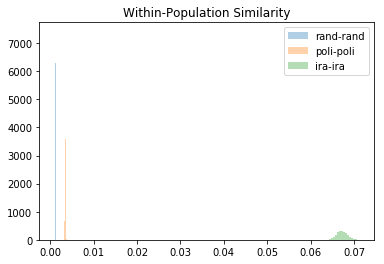

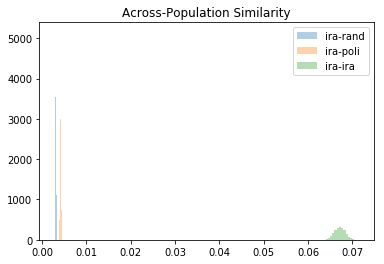

In [19]:
twitter_overlap_rand_poli = top_yt_chans_map_twitter["random"].intersection(top_yt_chans_map_twitter["political"])
twitter_overlap_rand_ira = top_yt_chans_map_twitter["random"].intersection(top_yt_chans_map_twitter["ira"])
twitter_overlap_poli_ira = top_yt_chans_map_twitter["political"].intersection(top_yt_chans_map_twitter["ira"])

print("Rand->Poli Overlap:", len(twitter_overlap_rand_poli))
print("Rand->IRA Overlap:", len(twitter_overlap_rand_ira))
print("Poli->IRA Overlap:", len(twitter_overlap_poli_ira))

twitter_user_links_mat_rand = channels_to_norm_matrix(twitter_yt_df_rand, top_yt_chans_map_twitter["random"], "user_id")
twitter_user_links_mat_poli = channels_to_norm_matrix(twitter_yt_df_poli, top_yt_chans_map_twitter["political"], "user_id")
twitter_user_links_mat_ira = channels_to_norm_matrix(twitter_yt_df_ira, top_yt_chans_map_twitter["ira"], "user_id")

# Calculate pairwise similarity among users across populations
t2t_rand_rand_sim = sklearn.metrics.pairwise.cosine_similarity(twitter_user_links_mat_rand, twitter_user_links_mat_rand)
t2t_poli_poli_sim = sklearn.metrics.pairwise.cosine_similarity(twitter_user_links_mat_poli, twitter_user_links_mat_poli)
t2t_ira_ira_sim = sklearn.metrics.pairwise.cosine_similarity(twitter_user_links_mat_ira, twitter_user_links_mat_ira)

t2t_ira_rand_sim = sklearn.metrics.pairwise.cosine_similarity(
    channels_to_norm_matrix(twitter_yt_df_ira, twitter_overlap_rand_ira, "user_id"), 
    channels_to_norm_matrix(twitter_yt_df_rand, twitter_overlap_rand_ira, "user_id"))
t2t_ira_poli_sim = sklearn.metrics.pairwise.cosine_similarity(
    channels_to_norm_matrix(twitter_yt_df_ira, twitter_overlap_poli_ira, "user_id"), 
    channels_to_norm_matrix(twitter_yt_df_poli, twitter_overlap_poli_ira, "user_id"))
t2t_rand_poli_sim = sklearn.metrics.pairwise.cosine_similarity(
    channels_to_norm_matrix(twitter_yt_df_rand, twitter_overlap_rand_poli, "user_id"), 
    channels_to_norm_matrix(twitter_yt_df_poli, twitter_overlap_rand_poli, "user_id"))

# Collapse similarities down to get the mean similarity for each user on the left to all users on the right
#. note the minus 1 and reduction of shape by 1 for the within-platform groups, which I do to remove the 
#. self-similarity effect
t2t_rand_rand_sim_avg = (np.sum(t2t_rand_rand_sim, axis=1) - 1) / (twitter_user_links_mat_rand.shape[0] - 1)
t2t_poli_poli_sim_avg = (np.sum(t2t_poli_poli_sim, axis=1) - 1) / (twitter_user_links_mat_poli.shape[0] - 1)
t2t_ira_ira_sim_avg = (np.sum(t2t_ira_ira_sim, axis=1) - 1) / (twitter_user_links_mat_ira.shape[0] - 1)
t2t_ira_rand_sim_avg = np.mean(t2t_ira_rand_sim, axis=1)
t2t_ira_poli_sim_avg = np.mean(t2t_ira_poli_sim, axis=1)
t2t_ira_ira_sim_avg = np.mean(t2t_ira_ira_sim, axis=1)
t2t_rand_poli_sim_avg = np.mean(t2t_rand_poli_sim, axis=1)

# Show similarity distribution within populations in this platform
t2t_rand_rand_sim_avg_bootstrap = [sklearn.utils.resample(t2t_rand_rand_sim_avg, replace=True, n_samples=t2t_rand_rand_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
t2t_poli_poli_sim_avg_bootstrap = [sklearn.utils.resample(t2t_poli_poli_sim_avg, replace=True, n_samples=t2t_poli_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
t2t_ira_ira_sim_avg_bootstrap = [sklearn.utils.resample(t2t_ira_ira_sim_avg, replace=True, n_samples=t2t_ira_ira_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]

plt.hist(t2t_rand_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="rand-rand")
plt.hist(t2t_poli_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="poli-poli")
plt.hist(t2t_ira_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-ira")

plt.title("Within-Population Similarity")
plt.legend()
plt.show()

# Show similarity distribution across populations in this platform
t2t_ira_rand_sim_avg_bootstrap = [sklearn.utils.resample(t2t_ira_rand_sim_avg, replace=True, n_samples=t2t_ira_rand_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
t2t_ira_poli_sim_avg_bootstrap = [sklearn.utils.resample(t2t_ira_poli_sim_avg, replace=True, n_samples=t2t_ira_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
t2t_ira_ira_sim_avg_bootstrap = [sklearn.utils.resample(t2t_ira_ira_sim_avg, replace=True, n_samples=t2t_ira_ira_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]

plt.hist(t2t_ira_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-rand")
plt.hist(t2t_ira_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-poli")
plt.hist(t2t_ira_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-ira")

plt.title("Across-Population Similarity")
plt.legend()
plt.show()

In [20]:
print("Random-Random:", np.array(t2t_rand_rand_sim_avg_bootstrap).mean(), np.array(t2t_rand_rand_sim_avg_bootstrap).var())
print("Russian IRA-Random:", np.array(t2t_ira_rand_sim_avg_bootstrap).mean(), np.array(t2t_ira_rand_sim_avg_bootstrap).var())
print("Russian IRA-Political:", np.array(t2t_ira_poli_sim_avg_bootstrap).mean(), np.array(t2t_ira_poli_sim_avg_bootstrap).var())


Random-Random: 0.0011968533568272896 2.958622639367535e-09
Russian IRA-Random: 0.003090054814739976 6.247398214943342e-09
Russian IRA-Political: 0.004145068404626064 1.802746907776989e-08


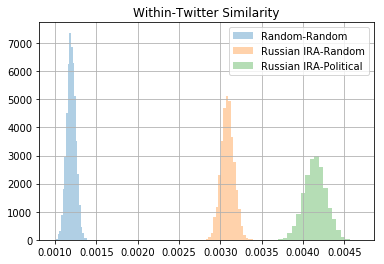

In [21]:
plt.hist(t2t_rand_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Random-Random")
plt.hist(t2t_ira_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Random")
plt.hist(t2t_ira_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Political")

plt.title("Within-Twitter Similarity")
plt.legend()
plt.grid()
plt.show()

Rand->Poli Overlap: 70
Rand->IRA Overlap: 8
Poli->IRA Overlap: 18


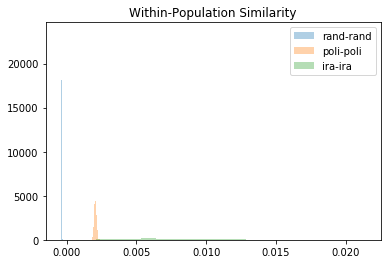

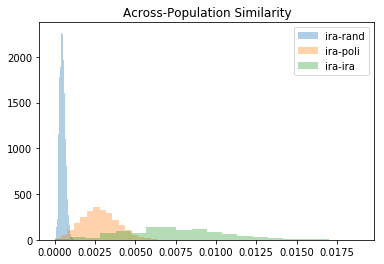

In [22]:
reddit_overlap_rand_poli = top_yt_chans_map_reddit["random"].intersection(top_yt_chans_map_reddit["political"])
reddit_overlap_rand_ira = top_yt_chans_map_reddit["random"].intersection(top_yt_chans_map_reddit["ira"])
reddit_overlap_poli_ira = top_yt_chans_map_reddit["political"].intersection(top_yt_chans_map_reddit["ira"])

print("Rand->Poli Overlap:", len(reddit_overlap_rand_poli))
print("Rand->IRA Overlap:", len(reddit_overlap_rand_ira))
print("Poli->IRA Overlap:", len(reddit_overlap_poli_ira))

reddit_user_links_mat_rand = channels_to_norm_matrix(reddit_yt_df_rand, top_yt_chans_map_twitter["random"], "user_name")
reddit_user_links_mat_poli = channels_to_norm_matrix(reddit_yt_df_poli, top_yt_chans_map_twitter["political"], "user_name")
reddit_user_links_mat_ira = channels_to_norm_matrix(reddit_yt_df_ira, top_yt_chans_map_twitter["ira"], "user_name")

# Calculate pairwise similarity among users across populations
r2r_rand_rand_sim = sklearn.metrics.pairwise.cosine_similarity(reddit_user_links_mat_rand, reddit_user_links_mat_rand)
r2r_poli_poli_sim = sklearn.metrics.pairwise.cosine_similarity(reddit_user_links_mat_poli, reddit_user_links_mat_poli)
r2r_ira_ira_sim = sklearn.metrics.pairwise.cosine_similarity(reddit_user_links_mat_ira, reddit_user_links_mat_ira)

r2r_ira_rand_sim = sklearn.metrics.pairwise.cosine_similarity(
    channels_to_norm_matrix(reddit_yt_df_ira, reddit_overlap_rand_ira, "user_name"), 
    channels_to_norm_matrix(reddit_yt_df_rand, reddit_overlap_rand_ira, "user_name"))
r2r_ira_poli_sim = sklearn.metrics.pairwise.cosine_similarity(
    channels_to_norm_matrix(reddit_yt_df_ira, reddit_overlap_poli_ira, "user_name"), 
    channels_to_norm_matrix(reddit_yt_df_poli, reddit_overlap_poli_ira, "user_name"))
r2r_rand_poli_sim = sklearn.metrics.pairwise.cosine_similarity(
    channels_to_norm_matrix(reddit_yt_df_rand, reddit_overlap_rand_poli, "user_name"), 
    channels_to_norm_matrix(reddit_yt_df_poli, reddit_overlap_rand_poli, "user_name"))

# Collapse similarities down to get the mean similarity for each user on the left to all users on the right
#. note the minus 1 and reduction of shape by 1 for the within-platform groups, which I do to remove the 
#. self-similarity effect
r2r_rand_rand_sim_avg = (np.sum(r2r_rand_rand_sim, axis=1) - 1) / (reddit_user_links_mat_rand.shape[0] - 1)
r2r_poli_poli_sim_avg = (np.sum(r2r_poli_poli_sim, axis=1) - 1) / (reddit_user_links_mat_poli.shape[0] - 1)
r2r_ira_ira_sim_avg = (np.sum(r2r_ira_ira_sim, axis=1) - 1) / (reddit_user_links_mat_ira.shape[0] - 1)
r2r_ira_rand_sim_avg = np.mean(r2r_ira_rand_sim, axis=1)
r2r_ira_poli_sim_avg = np.mean(r2r_ira_poli_sim, axis=1)
r2r_ira_ira_sim_avg = np.mean(r2r_ira_ira_sim, axis=1)
r2r_rand_poli_sim_avg = np.mean(r2r_rand_poli_sim, axis=1)

# Show similarity distribution within populations in this platform
r2r_rand_rand_sim_avg_bootstrap = [sklearn.utils.resample(r2r_rand_rand_sim_avg, replace=True, n_samples=r2r_rand_rand_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2r_poli_poli_sim_avg_bootstrap = [sklearn.utils.resample(r2r_poli_poli_sim_avg, replace=True, n_samples=r2r_poli_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2r_ira_ira_sim_avg_bootstrap = [sklearn.utils.resample(r2r_ira_ira_sim_avg, replace=True, n_samples=r2r_ira_ira_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]

plt.hist(r2r_rand_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="rand-rand")
plt.hist(r2r_poli_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="poli-poli")
plt.hist(r2r_ira_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-ira")

plt.title("Within-Population Similarity")
plt.legend()
plt.show()

# Show similarity distribution across populations in this platform
r2r_ira_rand_sim_avg_bootstrap = [sklearn.utils.resample(r2r_ira_rand_sim_avg, replace=True, n_samples=r2r_ira_rand_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2r_ira_poli_sim_avg_bootstrap = [sklearn.utils.resample(r2r_ira_poli_sim_avg, replace=True, n_samples=r2r_ira_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2r_ira_ira_sim_avg_bootstrap = [sklearn.utils.resample(r2r_ira_ira_sim_avg, replace=True, n_samples=r2r_ira_ira_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]

plt.hist(r2r_ira_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-rand")
plt.hist(r2r_ira_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-poli")
plt.hist(r2r_ira_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-ira")

plt.title("Across-Population Similarity")
plt.legend()
plt.show()

In [23]:
print("Random-Random:", np.array(r2r_rand_rand_sim_avg_bootstrap).mean(), np.array(r2r_rand_rand_sim_avg_bootstrap).var())
print("Russian IRA-Random:", np.array(r2r_ira_rand_sim_avg_bootstrap).mean(), np.array(r2r_ira_rand_sim_avg_bootstrap).var())
print("Russian IRA-Political:", np.array(r2r_ira_poli_sim_avg_bootstrap).mean(), np.array(r2r_ira_poli_sim_avg_bootstrap).var())


Random-Random: -0.000353297324256145 2.9763386613720753e-10
Russian IRA-Random: 0.0004909598839556023 2.98464321336416e-08
Russian IRA-Political: 0.0028153376998974 1.3370645454041288e-06


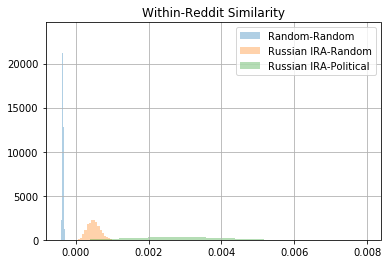

In [24]:
plt.hist(r2r_rand_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Random-Random")
plt.hist(r2r_ira_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Random")
plt.hist(r2r_ira_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Political")

plt.title("Within-Reddit Similarity")
plt.legend()
plt.grid()
plt.show()

In [25]:
# Test whether the within-group similarities across the three populations are equal
f_stat, p_val = scipy.stats.f_oneway(
    r2r_rand_rand_sim_avg_bootstrap, 
    r2r_ira_rand_sim_avg_bootstrap, 
    r2r_ira_poli_sim_avg_bootstrap)
print("p-value for ANOVA:", p_val, f_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    r2r_ira_rand_sim_avg_bootstrap, 
    r2r_ira_poli_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test between IRA-Rand and IRA-Poli:", p_val, t_stat)

p-value for ANOVA: 0.0 29535.579092224365
p-value for Welch's t-Test between IRA-Rand and IRA-Poli: 0.0 -140.5653164239627


Random Overlap: 73
Political Overlap: 127
IRA Overlap: 8


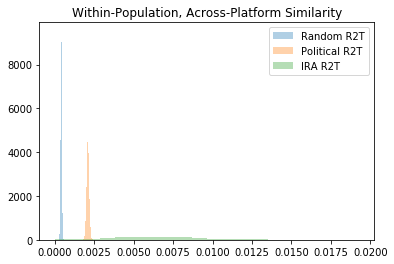

In [26]:
r2t_overlap_rand = top_yt_chans_map_reddit["random"].intersection(top_yt_chans_map_twitter["random"])
r2t_overlap_poli = top_yt_chans_map_reddit["political"].intersection(top_yt_chans_map_twitter["political"])
r2t_overlap_ira = top_yt_chans_map_reddit["ira"].intersection(top_yt_chans_map_twitter["ira"])

print("Random Overlap:", len(r2t_overlap_rand))
print("Political Overlap:", len(r2t_overlap_poli))
print("IRA Overlap:", len(r2t_overlap_ira))

# Calculate pairwise similarity among users across platforms
r2t_rand_sim = sklearn.metrics.pairwise.cosine_similarity(
    channels_to_norm_matrix(reddit_yt_df_rand, r2t_overlap_rand, "user_name"), 
    channels_to_norm_matrix(twitter_yt_df_rand, r2t_overlap_rand, "user_id"))
r2t_poli_sim = sklearn.metrics.pairwise.cosine_similarity(
    channels_to_norm_matrix(reddit_yt_df_poli, r2t_overlap_poli, "user_name"), 
    channels_to_norm_matrix(twitter_yt_df_poli, r2t_overlap_poli, "user_id"))
r2t_ira_sim = sklearn.metrics.pairwise.cosine_similarity(
    channels_to_norm_matrix(reddit_yt_df_ira, r2t_overlap_ira, "user_name"), 
    channels_to_norm_matrix(twitter_yt_df_ira, r2t_overlap_ira, "user_id"))

# Collapse similarities down to get the mean similarity for each user on the left to all users on the right
r2t_rand_sim_avg = np.mean(r2t_rand_sim, axis=1)
r2t_poli_sim_avg = np.mean(r2t_poli_sim, axis=1)
r2t_ira_sim_avg = np.mean(r2t_ira_sim, axis=1)

# Show similarity distribution within populations in this platform
r2t_rand_sim_avg_bootstrap = [sklearn.utils.resample(r2t_rand_sim_avg, replace=True, n_samples=r2t_rand_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2t_poli_sim_avg_bootstrap = [sklearn.utils.resample(r2t_poli_sim_avg, replace=True, n_samples=r2t_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2t_ira_sim_avg_bootstrap = [sklearn.utils.resample(r2t_ira_sim_avg, replace=True, n_samples=r2t_ira_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]

plt.hist(r2t_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Random R2T")
plt.hist(r2t_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Political R2T")
plt.hist(r2t_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="IRA R2T")

plt.title("Within-Population, Across-Platform Similarity")
plt.legend()
plt.show()



In [27]:
print("Random-R2T:", np.array(r2t_rand_sim_avg_bootstrap).mean(), np.array(r2t_rand_sim_avg_bootstrap).var())
print("Political-R2T:", np.array(r2t_poli_sim_avg_bootstrap).mean(), np.array(r2t_poli_sim_avg_bootstrap).var())
print("Russian IRA-R2T:", np.array(r2t_ira_sim_avg_bootstrap).mean(), np.array(r2t_ira_sim_avg_bootstrap).var())


Random-R2T: 0.0004235715895865953 1.7874722389748896e-09
Political-R2T: 0.0021107836831806394 6.897928076259002e-09
Russian IRA-R2T: 0.006558005491178176 8.723892914624505e-06


In [28]:
print("Russian IRA-R2T:", np.array(r2t_ira_sim_avg_bootstrap).mean(), np.array(r2t_ira_sim_avg_bootstrap).var())
print("Russian IRA-RRandom:", np.array(r2r_ira_rand_sim_avg_bootstrap).mean(), np.array(r2r_ira_rand_sim_avg_bootstrap).var())
print("Russian IRA-RPoli:", np.array(r2r_ira_poli_sim_avg_bootstrap).mean(), np.array(r2r_ira_poli_sim_avg_bootstrap).var())


Russian IRA-R2T: 0.006558005491178176 8.723892914624505e-06
Russian IRA-RRandom: 0.0004909598839556023 2.98464321336416e-08
Russian IRA-RPoli: 0.0028153376998974 1.3370645454041288e-06


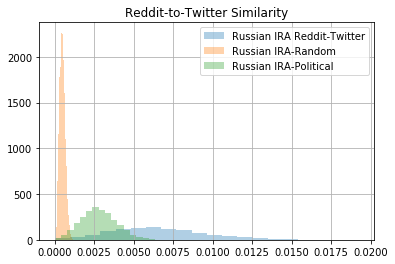

In [29]:
plt.hist(r2t_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA Reddit-Twitter")
plt.hist(r2r_ira_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Random")
plt.hist(r2r_ira_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Political")

plt.title("Reddit-to-Twitter Similarity")
plt.legend()
plt.grid()
plt.show()

In [30]:
# Test whether the within-group similarities across the three populations are equal
f_stat, p_val = scipy.stats.f_oneway(
    r2t_ira_sim_avg_bootstrap, 
    r2r_ira_rand_sim_avg_bootstrap, 
    r2r_ira_poli_sim_avg_bootstrap)
print("p-value for ANOVA:", p_val, f_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    r2t_ira_sim_avg_bootstrap, 
    r2r_ira_rand_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test between Twitter-Reddit and IRA-Rand:", p_val, t_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    r2t_ira_sim_avg_bootstrap,
    r2r_ira_poli_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test between Twitter-Reddit and IRA-Poli:", p_val, t_stat)

p-value for ANOVA: 0.0 13925.573611519707
p-value for Welch's t-Test between Twitter-Reddit and IRA-Rand: 0.0 144.98464936994742
p-value for Welch's t-Test between Twitter-Reddit and IRA-Poli: 0.0 83.42634013641516


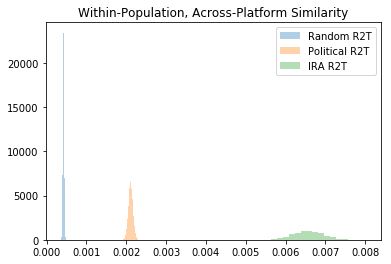

In [31]:
t2r_rand_sim = sklearn.metrics.pairwise.cosine_similarity(
    channels_to_norm_matrix(twitter_yt_df_rand, r2t_overlap_rand, "user_id"), 
    channels_to_norm_matrix(reddit_yt_df_rand, r2t_overlap_rand, "user_name"))
t2r_poli_sim = sklearn.metrics.pairwise.cosine_similarity(
    channels_to_norm_matrix(twitter_yt_df_poli, r2t_overlap_poli, "user_id"), 
    channels_to_norm_matrix(reddit_yt_df_poli, r2t_overlap_poli, "user_name"))
t2r_ira_sim = sklearn.metrics.pairwise.cosine_similarity(
    channels_to_norm_matrix(twitter_yt_df_ira, r2t_overlap_ira, "user_id"), 
    channels_to_norm_matrix(reddit_yt_df_ira, r2t_overlap_ira, "user_name"))

# Collapse similarities down to get the mean similarity for each user on the left to all users on the right
t2r_rand_sim_avg = np.mean(t2r_rand_sim, axis=1)
t2r_poli_sim_avg = np.mean(t2r_poli_sim, axis=1)
t2r_ira_sim_avg = np.mean(t2r_ira_sim, axis=1)

# Show similarity distribution within populations in this platform
t2r_rand_sim_avg_bootstrap = [sklearn.utils.resample(t2r_rand_sim_avg, replace=True, n_samples=t2r_rand_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
t2r_poli_sim_avg_bootstrap = [sklearn.utils.resample(t2r_poli_sim_avg, replace=True, n_samples=t2r_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
t2r_ira_sim_avg_bootstrap = [sklearn.utils.resample(t2r_ira_sim_avg, replace=True, n_samples=t2r_ira_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]

plt.hist(t2r_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Random R2T")
plt.hist(t2r_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Political R2T")
plt.hist(t2r_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="IRA R2T")

plt.title("Within-Population, Across-Platform Similarity")
plt.legend()
plt.show()




In [32]:
print("Russian IRA-T2R:", np.array(t2r_ira_sim_avg_bootstrap).mean(), np.array(t2r_ira_sim_avg_bootstrap).var())
print("Russian IRA-TRandom:", np.array(t2t_ira_rand_sim_avg_bootstrap).mean(), np.array(t2t_ira_rand_sim_avg_bootstrap).var())
print("Russian IRA-TPoli:", np.array(t2t_ira_poli_sim_avg_bootstrap).mean(), np.array(t2t_ira_poli_sim_avg_bootstrap).var())



Russian IRA-T2R: 0.006565320145965732 1.447369393152545e-07
Russian IRA-TRandom: 0.003090054814739976 6.247398214943342e-09
Russian IRA-TPoli: 0.004145068404626064 1.802746907776989e-08


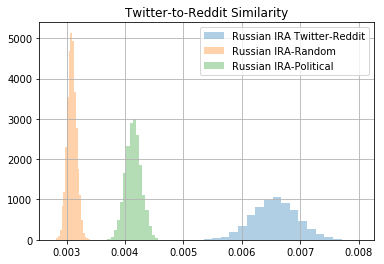

In [33]:
plt.hist(t2r_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA Twitter-Reddit")
plt.hist(t2t_ira_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Random")
plt.hist(t2t_ira_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Political")

plt.title("Twitter-to-Reddit Similarity")
plt.legend()
plt.grid()
plt.show()

In [34]:
# Test whether the within-group similarities across the three populations are equal
f_stat, p_val = scipy.stats.f_oneway(
    t2r_ira_sim_avg_bootstrap, 
    t2t_ira_rand_sim_avg_bootstrap, 
    t2t_ira_poli_sim_avg_bootstrap)
print("p-value for ANOVA:", p_val, f_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    t2r_ira_sim_avg_bootstrap, 
    t2t_ira_rand_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test between Twitter-Reddit and IRA-Rand:", p_val, t_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    t2r_ira_sim_avg_bootstrap,
    t2t_ira_poli_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test between Twitter-Reddit and IRA-Poli:", p_val, t_stat)

p-value for ANOVA: 0.0 281701.2024585687
p-value for Welch's t-Test between Twitter-Reddit and IRA-Rand: 0.0 632.3588302277733
p-value for Welch's t-Test between Twitter-Reddit and IRA-Poli: 0.0 424.1528481971843


In [35]:
## Full Cross-Comparison

### Other comparisons
t2t_rand_poli_sim_avg_bootstrap = [sklearn.utils.resample(t2t_rand_poli_sim_avg, replace=True, n_samples=t2t_rand_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2r_rand_poli_sim_avg_bootstrap = [sklearn.utils.resample(r2r_rand_poli_sim_avg, replace=True, n_samples=r2r_rand_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]


In [36]:
print("\t", "Random", "\t\t", "Political", "\t\t", "IRA", "\t\t", "Other")
print("\t", "mu", "sigma^2", "mu", "sigma^2", "mu", "sigma^2", "mu", "sigma^2")

print("Reddit")
print("Random:", 
    np.array(r2r_rand_rand_sim_avg_bootstrap).mean(), 
    np.array(r2r_rand_rand_sim_avg_bootstrap).var(),
    np.array(r2r_rand_poli_sim_avg_bootstrap).mean(), 
    np.array(r2r_rand_poli_sim_avg_bootstrap).var(),
    np.array(r2r_ira_rand_sim_avg_bootstrap).mean(), 
    np.array(r2r_ira_rand_sim_avg_bootstrap).var(),
    np.array(r2t_rand_sim_avg_bootstrap).mean(), 
    np.array(r2t_rand_sim_avg_bootstrap).var(),
)

print("Political:", 
    np.array(r2r_rand_poli_sim_avg_bootstrap).mean(), 
    np.array(r2r_rand_poli_sim_avg_bootstrap).var(),
    np.array(r2r_poli_poli_sim_avg_bootstrap).mean(), 
    np.array(r2r_poli_poli_sim_avg_bootstrap).var(),
    np.array(r2r_ira_poli_sim_avg_bootstrap).mean(), 
    np.array(r2r_ira_poli_sim_avg_bootstrap).var(),
    np.array(r2t_poli_sim_avg_bootstrap).mean(), 
    np.array(r2t_poli_sim_avg_bootstrap).var(),
)

print("IRA:", 
    np.array(r2r_ira_rand_sim_avg_bootstrap).mean(), 
    np.array(r2r_ira_rand_sim_avg_bootstrap).var(),
    np.array(r2r_ira_poli_sim_avg_bootstrap).mean(), 
    np.array(r2r_ira_poli_sim_avg_bootstrap).var(),
    np.array(r2r_ira_ira_sim_avg_bootstrap).mean(), 
    np.array(r2r_ira_ira_sim_avg_bootstrap).var(),
    np.array(r2t_ira_sim_avg_bootstrap).mean(), 
    np.array(r2t_ira_sim_avg_bootstrap).var(),
)

print("Twitter")
print("Random:", 
    np.array(t2t_rand_rand_sim_avg_bootstrap).mean(), 
    np.array(t2t_rand_rand_sim_avg_bootstrap).var(),
    np.array(t2t_rand_poli_sim_avg_bootstrap).mean(), 
    np.array(t2t_rand_poli_sim_avg_bootstrap).var(),
    np.array(t2t_ira_rand_sim_avg_bootstrap).mean(), 
    np.array(t2t_ira_rand_sim_avg_bootstrap).var(),
    np.array(t2r_rand_sim_avg_bootstrap).mean(), 
    np.array(t2r_rand_sim_avg_bootstrap).var(),
)

print("Political:", 
    np.array(t2t_rand_poli_sim_avg_bootstrap).mean(), 
    np.array(t2t_rand_poli_sim_avg_bootstrap).var(),
    np.array(t2t_poli_poli_sim_avg_bootstrap).mean(), 
    np.array(t2t_poli_poli_sim_avg_bootstrap).var(),
    np.array(t2t_ira_poli_sim_avg_bootstrap).mean(), 
    np.array(t2t_ira_poli_sim_avg_bootstrap).var(),
    np.array(t2r_poli_sim_avg_bootstrap).mean(), 
    np.array(t2r_poli_sim_avg_bootstrap).var(),
)

print("IRA:", 
    np.array(t2t_ira_rand_sim_avg_bootstrap).mean(), 
    np.array(t2t_ira_rand_sim_avg_bootstrap).var(),
    np.array(t2t_ira_poli_sim_avg_bootstrap).mean(), 
    np.array(t2t_ira_poli_sim_avg_bootstrap).var(),
    np.array(t2t_ira_ira_sim_avg_bootstrap).mean(), 
    np.array(t2t_ira_ira_sim_avg_bootstrap).var(),
    np.array(t2r_ira_sim_avg_bootstrap).mean(), 
    np.array(t2r_ira_sim_avg_bootstrap).var(),
)



	 Random 		 Political 		 IRA 		 Other
	 mu sigma^2 mu sigma^2 mu sigma^2 mu sigma^2
Reddit
Random: -0.000353297324256145 2.9763386613720753e-10 0.0005226218660067393 2.3450027896025437e-09 0.0004909598839556023 2.98464321336416e-08 0.0004235715895865953 1.7874722389748896e-09
Political: 0.0005226218660067393 2.3450027896025437e-09 0.002055875088877557 7.2724543529363975e-09 0.0028153376998974 1.3370645454041288e-06 0.0021107836831806394 6.897928076259002e-09
IRA: 0.0004909598839556023 2.98464321336416e-08 0.0028153376998974 1.3370645454041288e-06 0.0075370171398620525 9.848082257035323e-06 0.006558005491178176 8.723892914624505e-06
Twitter
Random: 0.0011968533568272896 2.958622639367535e-09 0.0021223618237638455 8.487182415858578e-09 0.003090054814739976 6.247398214943342e-09 0.00042266987266054086 2.9442562691196485e-10
Political: 0.0021223618237638455 8.487182415858578e-09 0.0034895995484698988 8.674632424754867e-09 0.004145068404626064 1.802746907776989e-08 0.002110153790792836 3.25

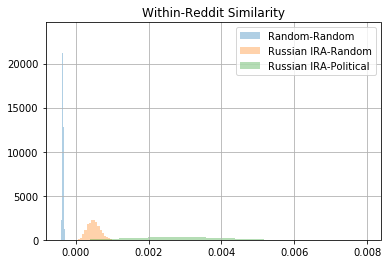

In [37]:
plt.hist(r2r_rand_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Random-Random")
plt.hist(r2r_ira_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Random")
plt.hist(r2r_ira_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Political")

plt.title("Within-Reddit Similarity")
plt.legend()
plt.grid()
plt.show()

In [38]:
# Test whether the within-group similarities across the three populations are equal
f_stat, p_val = scipy.stats.f_oneway(
    r2r_rand_rand_sim_avg_bootstrap, 
    r2r_ira_rand_sim_avg_bootstrap, 
    r2r_ira_poli_sim_avg_bootstrap)
print("p-value for ANOVA:", p_val, f_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    r2r_ira_rand_sim_avg_bootstrap, 
    r2r_ira_poli_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test :", p_val, t_stat)

p-value for ANOVA: 0.0 29535.579092224365
p-value for Welch's t-Test : 0.0 -140.5653164239627


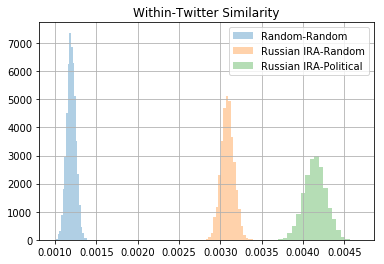

In [39]:
plt.hist(t2t_rand_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Random-Random")
plt.hist(t2t_ira_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Random")
plt.hist(t2t_ira_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Political")

plt.title("Within-Twitter Similarity")
plt.legend()
plt.grid()
plt.show()

In [40]:
# Test whether the within-group similarities across the three populations are equal
f_stat, p_val = scipy.stats.f_oneway(
    t2t_rand_rand_sim_avg_bootstrap, 
    t2t_ira_rand_sim_avg_bootstrap, 
    t2t_ira_poli_sim_avg_bootstrap)
print("p-value for ANOVA:", p_val, f_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    t2t_ira_rand_sim_avg_bootstrap, 
    t2t_ira_poli_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test :", p_val, t_stat)

p-value for ANOVA: 0.0 1228869.2698823132
p-value for Welch's t-Test : 0.0 -478.76367295543577


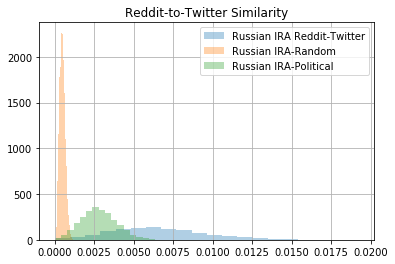

In [41]:
plt.hist(r2t_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA Reddit-Twitter")
plt.hist(r2r_ira_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Random")
plt.hist(r2r_ira_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Political")

plt.title("Reddit-to-Twitter Similarity")
plt.legend()
plt.grid()
plt.show()

In [42]:
# Test whether the within-group similarities across the three populations are equal
f_stat, p_val = scipy.stats.f_oneway(
    r2t_ira_sim_avg_bootstrap, 
    r2r_ira_rand_sim_avg_bootstrap, 
    r2r_ira_poli_sim_avg_bootstrap)
print("p-value for ANOVA:", p_val, f_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    r2t_ira_sim_avg_bootstrap, 
    r2r_ira_rand_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test :", p_val, t_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    r2t_ira_sim_avg_bootstrap,
    r2r_ira_poli_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test :", p_val, t_stat)

p-value for ANOVA: 0.0 13925.573611519707
p-value for Welch's t-Test : 0.0 144.98464936994742
p-value for Welch's t-Test : 0.0 83.42634013641516


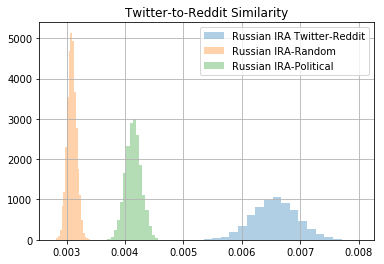

In [43]:
plt.hist(t2r_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA Twitter-Reddit")
plt.hist(t2t_ira_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Random")
plt.hist(t2t_ira_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Political")

plt.title("Twitter-to-Reddit Similarity")
plt.legend()
plt.grid()
plt.show()

In [44]:
# Test whether the within-group similarities across the three populations are equal
f_stat, p_val = scipy.stats.f_oneway(
    t2r_ira_sim_avg_bootstrap, 
    t2t_ira_rand_sim_avg_bootstrap, 
    t2t_ira_poli_sim_avg_bootstrap)
print("p-value for ANOVA:", p_val, f_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    t2r_ira_sim_avg_bootstrap, 
    t2t_ira_rand_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test :", p_val, t_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    t2r_ira_sim_avg_bootstrap,
    t2t_ira_poli_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test :", p_val, t_stat)

p-value for ANOVA: 0.0 281701.2024585687
p-value for Welch's t-Test : 0.0 632.3588302277733
p-value for Welch's t-Test : 0.0 424.1528481971843


In [45]:
channel_map_reddit = {row["channel_id"]:row["channel_title"] for _, row in reddit_yt_meta_df.iterrows()}
channel_map_twitter = {row["channel_id"]:row["channel_title"] for _, row in twitter_yt_meta_df.iterrows()}

print(len(top_yt_chans_map_reddit["ira"]), len(top_yt_chans_map_twitter["ira"]))
print("*"*100, "\nReddit:")
for x in sorted(top_yt_chans_map_reddit["ira"]):
    print(x, channel_map_reddit[x])
    
print("*"*100, "\nTwitter:")
for x in sorted(top_yt_chans_map_twitter["ira"]):
    print(x, channel_map_twitter[x])

127 250
**************************************************************************************************** 
Reddit:
UC07E0MabO1qktuSAwLPYClA Romain Levesque
UC0hkwSIzywVL0Unfh35aVHw Meme Militia
UC0pjFxM6b7fLO4hWZz1XwhA redha redha
UC16niRr50-MSBwiO3YDb3RA BBC News
UC1yBKRuGpC1tSM73A0ZjYjQ The Young Turks
UC2-BeLxzUBSs0uSrmzWhJuQ 20th Century Fox
UC2FUP1CtHRzUYtsFLuQLLMg Changers
UC2UIuUg8jvObCB69SVKim5w Amy Slack
UC2VnwPCW63NH9YTLvZj9qKA Charles Gaba
UC2YnEq5Fc5_zEO6bo0oNzCQ melanie martinez
UC3HvwOPH-xwVb1aWoVg7ohg 8BitDylan
UC49JMhfP3JaJlWoZru2hhUw Keep Up With The News
UC4UyF8vu2-QybvSMV07ZsbQ LifeMoments247
UC6ZFN9Tx6xh-skXCuRHCDpQ PBS NewsHour
UC6smmr3qaBCGztOoLoM_aSQ paultyree1
UC6xM7GvKd85duq5fw8qKBOQ Matt Orfalea
UC6ybAZHANiMTbaQAOO-_0wQ animal lovers
UC7TvL4GlQyMBLlUsTrN_C4Q corbettreport
UC7v3-2K1N84V67IF-WTRG-Q Jeremy Jahns
UC7ygjE6Dmi0PBI5NuYj0x4g dailymailofficial24x7
UC8jD-AUseXkAQqfYW9vl8mw Super Epic Cats
UC9obdDRxQkmn_4YpcBMTYLw Tiger FunnyWorks
UCADX_BwgeiTFlnkg6tm

## Compare Identically Named Users

In [46]:
reddit_troll_names = pd.read_csv("../data/reddit_troll_accounts_20190206.csv")
twitter_troll_names = pd.read_csv("../data/twitter_russian_troll_accounts.csv")

In [47]:
cross_platform_users = set(twitter_troll_names["handle"].apply(str.lower))\
    .intersection(set(reddit_troll_names["username"].apply(str.lower)))

print("User count with the same ID:", len(cross_platform_users))
for u in cross_platform_users:
    print(u)

User count with the same ID: 19
southlonestar
matevidence
markhudson89
blacktolive
jenn_abrams
fuuncake
ten_gop
tebepizdec
wadeharriot
rebekahbennet
stephenbag
leecory
hyddrox
dorothiebell
1488reasons
deusxyx
toneporter
mr_clampin
bleepthepolice


In [48]:
deanon_df = pd.read_csv("../data/deanon_v2.csv")

In [49]:
deanon_map = {row["screen_name"].lower():row["userid"] for _, row in deanon_df.iterrows()}

In [50]:
for u in cross_platform_users:
    print(u, deanon_map.get(u))
    

southlonestar None
matevidence None
markhudson89 None
blacktolive None
jenn_abrams None
fuuncake None
ten_gop None
tebepizdec None
wadeharriot 349144213c3141c70f1021f47d801f6e7bb56dd7faa3302b023b0e82c0f70869
rebekahbennet None
stephenbag None
leecory None
hyddrox 396b0b6914e425ca53c49b7f1d6cfe9757eb7368c04c657a09d83b19a8f1251e
dorothiebell dfcf2c9017b25c825fa444e17e429f3a6e739bc44ca7db41645470fe4410ad25
1488reasons None
deusxyx 99299a75c967aa491b27d86a60c2ffe0a6156d1b0dcb4487917f48e7e1c7ef78
toneporter cd2f120a1666c87fac2ab045e1ff01b06be0814481d4e96234a13041b3a1a295
mr_clampin b61d47c22efd69b47675c296d5c54e2675da8977504225327611713990b4e784
bleepthepolice None


In [51]:
for u in cross_platform_users:
    hashed_u = deanon_map.get(u)
    print(u, deanon_map.get(u))
    
    if ( hashed_u is None ):
        continue
    
    local_reddit_df = reddit_yt_df_ira[reddit_yt_df_ira["user_name"] == u]
    local_twitter_df = twitter_yt_df_ira[twitter_yt_df_ira["user_id"] == hashed_u]

    local_reddit_tld = set(local_reddit_df["channel_id"].value_counts().index)
    local_twitter_tld = set(local_twitter_df["channel_id"].value_counts().index)

    common_tlds = set(local_twitter_tld).intersection(local_reddit_tld)
    print("\t", "Twitter Chans:", len(local_twitter_tld), "Reddit Chans:", len(local_reddit_tld))
    print("\t", "Chans in Common:", len(common_tlds))

    if ( len(common_tlds) == 0 ):
        continue
        
    local_sim = sklearn.metrics.pairwise.cosine_similarity(
        links_to_norm_matrix(local_reddit_df, common_tlds, "user_name"), 
        links_to_norm_matrix(local_twitter_df, common_tlds, "user_id"))
    print("\t", "Local Similarity:", local_sim)

southlonestar None
matevidence None
markhudson89 None
blacktolive None
jenn_abrams None
fuuncake None
ten_gop None
tebepizdec None
wadeharriot 349144213c3141c70f1021f47d801f6e7bb56dd7faa3302b023b0e82c0f70869
	 Twitter Chans: 57 Reddit Chans: 1
	 Chans in Common: 0
rebekahbennet None
stephenbag None
leecory None
hyddrox 396b0b6914e425ca53c49b7f1d6cfe9757eb7368c04c657a09d83b19a8f1251e
	 Twitter Chans: 175 Reddit Chans: 0
	 Chans in Common: 0
dorothiebell dfcf2c9017b25c825fa444e17e429f3a6e739bc44ca7db41645470fe4410ad25
	 Twitter Chans: 65 Reddit Chans: 0
	 Chans in Common: 0
1488reasons None
deusxyx 99299a75c967aa491b27d86a60c2ffe0a6156d1b0dcb4487917f48e7e1c7ef78
	 Twitter Chans: 49 Reddit Chans: 0
	 Chans in Common: 0
toneporter cd2f120a1666c87fac2ab045e1ff01b06be0814481d4e96234a13041b3a1a295
	 Twitter Chans: 42 Reddit Chans: 0
	 Chans in Common: 0
mr_clampin b61d47c22efd69b47675c296d5c54e2675da8977504225327611713990b4e784
	 Twitter Chans: 23 Reddit Chans: 0
	 Chans in Common: 0
bleepthe

In [52]:
for u in cross_platform_users:
    hashed_u = deanon_map.get(u)
    
    if ( hashed_u is None ):
        continue
    
    local_reddit_df = reddit_yt_df_ira[reddit_yt_df_ira["user_name"] == u]
    local_twitter_df = twitter_yt_df_ira[twitter_yt_df_ira["user_id"] == hashed_u]

    local_reddit_tld = set(local_reddit_df["channel_id"].value_counts().index)
    local_twitter_tld = set(local_twitter_df["channel_id"].value_counts().index)

    common_tlds = set(local_twitter_tld).intersection(local_reddit_tld)

    sim = 0.0
    if ( len(common_tlds) > 0 ):
        local_sim = sklearn.metrics.pairwise.cosine_similarity(
            links_to_norm_matrix(local_reddit_df, common_tlds, "user_name"), 
            links_to_norm_matrix(local_twitter_df, common_tlds, "user_id"))
        sim = local_sim[0]
        
    print("%s & %d & %d & %d & %f \\\\" % (u, len(local_reddit_tld), len(local_twitter_tld), len(common_tlds), sim))
    

wadeharriot & 1 & 57 & 0 & 0.000000 \\
hyddrox & 0 & 175 & 0 & 0.000000 \\
dorothiebell & 0 & 65 & 0 & 0.000000 \\
deusxyx & 0 & 49 & 0 & 0.000000 \\
toneporter & 0 & 42 & 0 & 0.000000 \\
mr_clampin & 0 & 23 & 0 & 0.000000 \\
